In [1]:
import numpy as np
import pandas as pd
import pickle
import string
import re
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.manifold import TSNE
from gensim.models import word2vec

# pd.set_option("display.max_columns", 2000)
# pd.set_option("display.max_rows", 2000)

%load_ext autoreload
%autoreload 2

In [2]:
df_videos_cleaned_v9 = pickle.load(open('../Data/df_videos_cleaned_v9.pickle', 'rb'))

### All the functions (Need to put these into a separate .py file)

In [3]:
def title_preprocessing(df):
    '''
    Input: Cleaned dataframe 
    Output: Tokenized titles in the dataframe 
    '''
    def preprocessing_pipeline(raw_text):
        ## Remove punctuations, except for apostrophes
        preprocessed_text_1 = raw_text.translate(str.maketrans('', '', string.punctuation.replace("'", "")))
        
        ## Remove numbers
        preprocessed_text_2 = re.sub('\w*\d\w*', '', preprocessed_text_1)
        
        ## Remove stopwords
        stopwords = spacy.lang.en.stop_words.STOP_WORDS
        
        preprocessed_text_3 = nlp(preprocessed_text_2)
        preprocessed_text_4 = [word.text for word in preprocessed_text_3 
                                    if str(word).lower() not in stopwords and word.text!= ' ']
        
        ## Lemmatization
        lemmatizer = WordNetLemmatizer()
        tag_map = defaultdict(lambda : wordnet.NOUN)
        tag_map['V'] = wordnet.VERB 
        tag_map['J'] = wordnet.ADJ
        tag_map['R'] = wordnet.ADV

        preprocessed_text_5 = [lemmatizer.lemmatize(word.lower(), tag_map[tag[0]]) 
                                    for word, tag in pos_tag(preprocessed_text_4)]
        
        preprocessed_text_6 = [word for word in preprocessed_text_5 if len(word)>1]
        
        return preprocessed_text_6
    
    df['Title'] = df['Title'].apply(preprocessing_pipeline)
            
    return df   

In [ ]:
def wordcloud(df, text_column, vectorizer):
    '''
    Input: Cleaned dataframe 
    Output: a Wordcloud viz showing most frequently represented words
    '''
    if text_column == 'Transcript':
        word_list = [[word[0] for word in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[word for word in doc] for doc in df['Title']]
        
    vec = vectorizer(tokenizer=lambda doc:doc, lowercase=False)
    matrix = vec.fit_transform(word_list).toarray()

In [4]:
def word2vec_plot(df, text_column, min_count, window):
    '''
    Input: Cleaned dataframe 
    Output: A t-SNE plot showing clusters based on Word2Vec embeddings
    '''
    ## Take the words out of the (word, POS) tuple in each transcript and put them into a list
    if text_column == 'Transcript':
        word_list = [[word[0] for word in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[word for word in doc] for doc in df['Title']]
    
    ## Initialize a Word2Vec model and set parameters
    model = word2vec.Word2Vec(word_list, min_count=min_count, window=window, ns_exponent = -10)
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    ## Create a plot using matplotlib
    plt.figure(figsize=(16, 12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    plt.tight_layout()
    plt.savefig('../Charts/word2vec_tsne_plot', dpi=600)

In [5]:
def word2vec_most_similar(df, text_column, min_count, window, word):
    '''
    Input: Cleaned dataframe 
    Output: 10 most similar words based on Word2Vec embeddings
    '''
    if text_column == 'Transcript':
        word_list = [[word[0] for word in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[word for word in doc] for doc in df['Title']]
        
    model = word2vec.Word2Vec(word_list, min_count=min_count, window=window, ns_exponent = -10)
    
    return model.most_similar(word)

In [6]:
def document_term_matrix_df(df, text_column, vectorizer):
    '''
    Input: Cleaned dataframe 
    Output: Document-term matrix in a dataframe
    '''
    ## Take the words out of the (word, POS) tuple, vectorize, and fit-transform into a matrix
    if text_column == 'Transcript':
        word_list = [[word[0] for word in doc] for doc in df['Transcript']]
    elif text_column == 'Title':
        word_list = [[word for word in doc] for doc in df['Title']]
        
    vec = vectorizer(tokenizer=lambda doc:doc, lowercase=False)
    matrix = vec.fit_transform(word_list).toarray()
    df_matrix = pd.DataFrame(matrix, columns=vec.get_feature_names())
        
    return df_matrix

In [7]:
def bad_videos(df, df_matrix_bad):
    '''
    Input: Cleaned dataframe and a document-term matrix for the bad videos
    Output: Dataframe of info on the bad videos
    '''
    indices = list(df_matrix_bad.index)
    df_bad = df.loc[indices]
    
    return df_bad

In [ ]:
def sentiment_analysis(df):
    '''
    Input: Cleaned dataframe 
    Output: Dataframe with a new column showing sentiment scores
    '''

### Video transcript word embeddings and frequency

#### Wordcloud

#### Visualizing Word2Vec Word Embeddings using t-SNE

<ipython-input-4-61dc6dce94a7>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


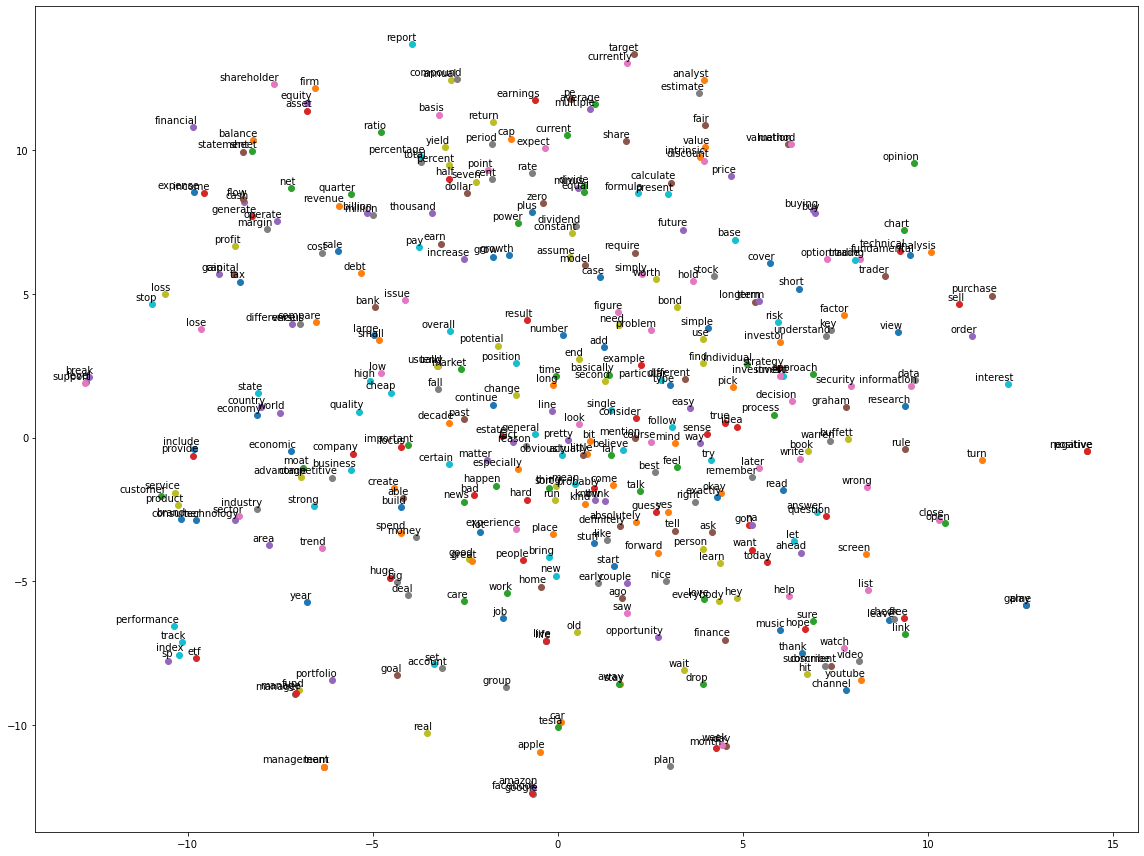

In [8]:
word2vec_plot(df_videos_cleaned_v9, 'Transcript', 1000, 5)

In [9]:
word2vec_most_similar(df_videos_cleaned_v9, 'Transcript', 1000, 5, 'best')

<ipython-input-5-4bc206018827>:13: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  return model.most_similar(word)


[('great', 0.6717149615287781),
 ('absolutely', 0.6415141224861145),
 ('ask', 0.6368708610534668),
 ('love', 0.6368061900138855),
 ('opinion', 0.6364638805389404),
 ('pick', 0.6363178491592407),
 ('know', 0.6040629148483276),
 ('think', 0.6019827723503113),
 ('experience', 0.5948983430862427),
 ('sort', 0.5904391407966614)]

#### Identifying bad quality videos with keyword frequency

In [10]:
df_matrix_transcript = document_term_matrix_df(df_videos_cleaned_v9, 'Transcript', CountVectorizer)

In [11]:
bad_videos_1 = df_matrix_transcript[
                         (df_matrix_transcript['best']>=1) 
                       & (df_matrix_transcript['pick']>=1)
                       & (df_matrix_transcript['technical']>=1)
                        ].sort_values('technical', ascending=False)
bad_videos_1

,','',a'right,aa,aaa,aachen,aagama,aahah,aahhaha,aai,...,átodayá,âlâ,ñamandu,óbuda,úbeda,única,​,’,刘德,华米
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
bad_videos(df_videos_cleaned_v9, bad_videos_1).head()

,Video_ID,Title,Upload Date,Duration,Views,Number of Likes,Description,Transcript,Topic,Topic Coefficient
27,HHvnYEGHDfA,HOW TO DO FUNDAMENTAL ANALYSIS AND WHAT STOCKS...,2020-07-27,89.433333,"2,216 views",126,HOW TO DO FUNDAMENTAL ANALYSIS AND WHAT STOCKS...,"[(hey, INTJ), (today, NOUN), (episode, NOUN), ...",General,0.111
1349,z1pX7LVR118,How to Learn Dividend Investing in a Week Ep.1,2020-04-20,45.950000,"38,842 views",1.9K,►https://www.instagram.com/garenphillips/\n\nh...,"[(wanna, PROPN), (learn, VERB), (best, ADJ), (...",General,0.099
116,f-IOiTQIhM0,EP#008 - What are 10 steps in investing proces...,2021-02-22,30.950000,769 views,46,Do you want to know the precise steps to becom...,"[(music, NOUN), (hello, INTJ), (welcome, INTJ)...",General,0.093
198,rNI166nMAFw,Technical Analysis Secrets: What Most Trading ...,2018-11-15,42.116667,"883,858 views",25K,Discover the truth about Technical Analysis — ...,"[(hey, INTJ), (hey, INTJ), (friend, NOUN), (we...",General,0.067
72,YbViBjP7zGk,How To Pick Stocks To Invest In - Fundamental ...,2020-01-21,8.500000,"1,936 views",170,How to pick the best stocks to trade: Should y...,"[(decide, VERB), (invest, VERB), (stock, NOUN)...",Technology Stocks,0.072


#### Sentiment analysis

### Video title word embeddings and frequency

#### Visualizing Word2Vec Word Embeddings using t-SNE

In [13]:
df_videos_cleaned_v9_title = title_preprocessing(df_videos_cleaned_v9)

<ipython-input-4-61dc6dce94a7>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


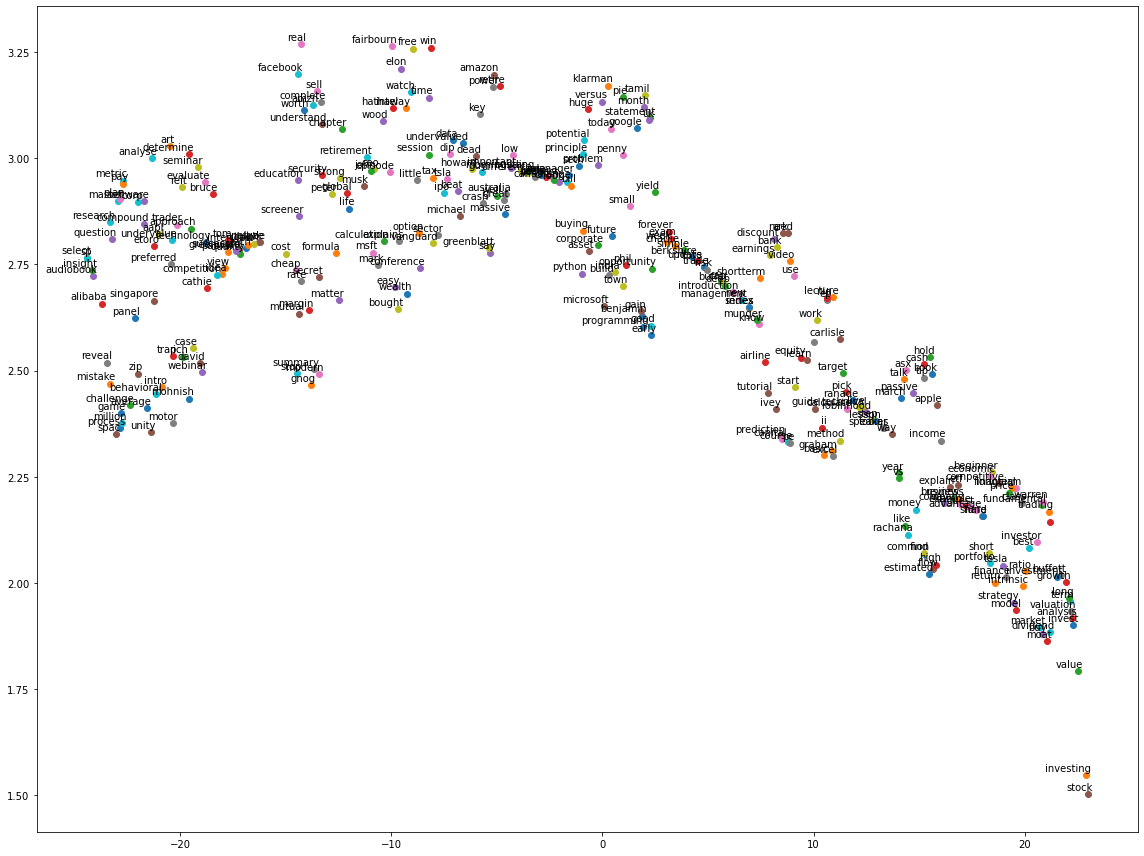

In [14]:
word2vec_plot(df_videos_cleaned_v9_title, 'Title', 5, 3)

In [15]:
word2vec_most_similar(df_videos_cleaned_v9_title, 'Title', 5, 3, 'trading')

<ipython-input-5-4bc206018827>:13: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  return model.most_similar(word)


[('valuation', 0.9998998045921326),
 ('stock', 0.9998972415924072),
 ('long', 0.9998937845230103),
 ('growth', 0.9998900294303894),
 ('investing', 0.9998890161514282),
 ('fundamental', 0.9998875260353088),
 ('term', 0.9998823404312134),
 ('dividend', 0.9998774528503418),
 ('analysis', 0.9998728632926941),
 ('value', 0.999870777130127)]

#### Identifying bad quality videos with keyword frequency

In [22]:
df_matrix_title = document_term_matrix_df(df_videos_cleaned_v9_title, 'Title', CountVectorizer)

In [25]:
bad_videos_2 = df_matrix_title[
                         (df_matrix_title['technical']>=1) 
#                        & (df_matrix_title['pick']>=1)
#                        & (df_matrix_title['technical']>=1)
                        ].sort_values('technical', ascending=False)
bad_videos_2

,,,,aaa,aal,aapl,ab,abbv,abbvie,abc,...,कैसे,क्या,निवेश,रणनीति,हैं,కోసం,చేస్తే,లో,瑞幸咖啡,蔚来
187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
bad_videos(df_videos_cleaned_v9_title, bad_videos_2)

,Video_ID,Title,Upload Date,Duration,Views,Number of Likes,Description,Transcript,Topic,Topic Coefficient
187,ZhddUgPyu-Y,"[primer, technical, analysis, technical, funda...",2018-11-09,3.200000,"4,922 views",36,NaN,"[(music, NOUN), (duration, NOUN), (time, NOUN)...",Technology Stocks,0.046
95,HhPY_genuWs,"[fundamental, analysis, technical, analysis, w...",2021-02-06,10.366667,"1,704 views",148,Limited time offer - Open FREE trading + demat...,"[(dear, ADJ), (viewer, NOUN), (video, NOUN), (...",General,0.078
15,fBe2w67elfI,"[avalanche, avax, beautiful, setup, technical,...",2021-03-04,9.916667,240 views,30,You can find me at Discord on,"[(youtube, PROPN), (mkg, PROPN), (crypto, PROP...",General,0.032
204,-JgnamVMAmE,"[invest, like, stock, superstar, fundamental, ...",2020-09-17,91.933333,"1,309 views",11,The American Association of Individual Investo...,"[(hello, INTJ), (welcome, INTJ), (tonight, NOU...",General,0.072
166,u_ain-0Y2U4,"[well, trading, investing, logic, technical, a...",2017-06-14,3.233333,190 views,3,Subscribe to Our Youtube Channel: https://goo....,"[(market, NOUN), (basic, ADJ), (trade, NOUN), ...",General,0.066
168,oZvtHMeFsKg,"[tsnp, humbl, stock, bullish, pattern, technic...",2021-02-24,11.716667,"1,007 views",52,TSNP (HUMBL) Stock Analysis: In this TSNP (HUM...,"[(everybody, PRON), (welcome, VERB), (money, N...",General,0.028
186,1gfNUUoC2HY,"[technical, fundamental, investing]",2017-04-22,4.650000,100 views,12,"Another investing for beginners lesson, today ...","[(hey, INTJ), (everybody, PRON), (welcome, VER...",General,0.063
192,cxOacVvaLaU,"[fundamental, analysis, technical, analysis]",2016-08-11,2.100000,194 views,4,What is Fundamental Analysis? What is Technica...,"[(fundamental, ADJ), (analysis, NOUN), (fundam...",General,0.054
198,rNI166nMAFw,"[technical, analysis, secret, trading, guru, t...",2018-11-15,42.116667,"883,858 views",25K,Discover the truth about Technical Analysis — ...,"[(hey, INTJ), (hey, INTJ), (friend, NOUN), (we...",General,0.067
201,wcK21QRXyx4,"[mara, stock, money, mara, stock, technical, f...",2021-02-28,11.266667,"1,175 views",61,MARA Stock Analysis: Marathon is a digital ass...,"[(everybody, PRON), (welcome, VERB), (money, N...",General,0.033
